In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import seaborn as sns
import joblib
import matplotlib.dates as mdates
import tensorflow

df =pd.read_csv("IXIC.csv")
df.head()
df.info()
df.set_index('Date', inplace=True, drop=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12824 entries, 0 to 12823
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       12824 non-null  object 
 1   Open       12824 non-null  float64
 2   High       12824 non-null  float64
 3   Low        12824 non-null  float64
 4   Close      12824 non-null  float64
 5   Adj Close  12824 non-null  float64
 6   Volume     12824 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 701.4+ KB


<ipython-input-34-6e1a033b00cc>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


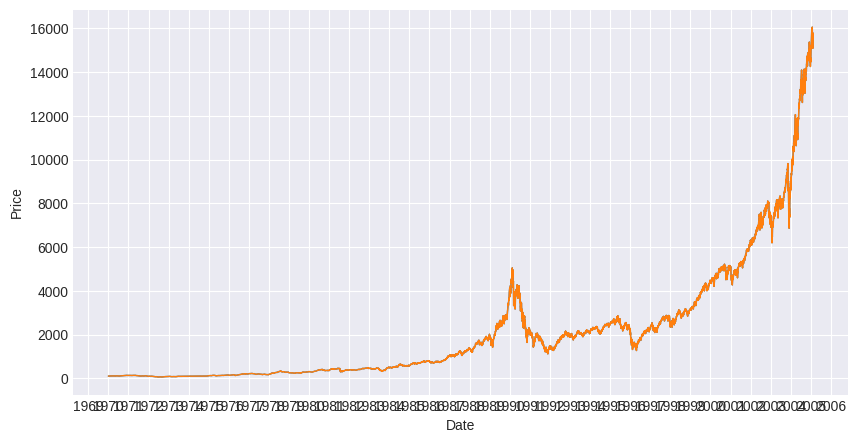

In [34]:
#只取收盤價
df=df.filter(["Close"])
df=df.rename(columns={"Close":"GT"})
df
#先視覺化看長怎樣
plt.style.use("seaborn-darkgrid")
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df.index, df['GT'], linewidth=1)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(df["GT"],linewidth=1)
plt.show()

在機器學習中，很多模型都需要輸入數據的數值範圍在一個固定的區間內，比如神經網絡需要輸入數據的值域在[0,1]或[-1,1]之間，因此使用MinMaxScaler按照線性比例將值縮放到[0,1]的範圍內，從而使所有數據都在指定的範圍內


In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_price=scaler.fit_transform(df.values)
scaled_price

array([[0.00282017],
       [0.00287266],
       [0.00286766],
       ...,
       [0.94799023],
       [0.97684619],
       [0.98309958]])

在決定資料集大小時問了chatgpt如何設定最準確,而它則回答要設定多少歷史數據作為輸入，需要根據具體的情況而定。如果使用較少的歷史數據作為輸入，模型可能會無法捕捉到較長期的趨勢和波動。如果使用較多的歷史數據作為輸入，則模型可能會受到過多的噪聲和無關因素的干擾，通常情況下，時間窗口大小可以在20到100個交易日之間調整，也因此我將60天作為dataset的大小，輸入項60天的收市價，輸出項為第61天的收市價


In [36]:
daysize=60
all_x,all_y=[],[]
for i in range(len(scaled_price)-daysize):
    x=scaled_price[i:i+daysize]
    y=scaled_price[i+daysize]
    all_x.append(x)
    all_y.append(y)

all_x,all_y=np.array(all_x),np.array(all_y)
all_x.shape
all_y.shape

(12764, 1)

In [45]:
#將資料的80%用來訓練，20%用來測試
split=0.8
train_size=round(all_x.shape[0]*split)
train_x,train_y=all_x[:train_size],all_y[:train_size]
test_x,test_y=all_x[train_size:],all_y[train_size:]

#這裡神經網路模型使用了4層，前兩層為LSTM，後兩層為dense

ＬＳＴＭ:LSTM (Long Short-Term Memory) 是一種循環神經網路，專門用於具時間連續性的數據上，使用兩層LSTM的原因是可以增加模型的複雜度，進而提高模型的預測能力。以便更好地預測未來的股價，第一層LSTM用於辨識輸入項的微觀特徵，第二層則用於辨識宏觀特徵使用。補充說明，第二層LSTM的return_sequences參數被設置為False，表示第二層LSTM只會輸出一次，這意味著第二層LSTM會將第一層LSTM輸出的序列轉化為一個向量，作為輸入傳遞給下一層。最終的Dense層和輸出層可以進一步處理這個向量，以生成最終的預測結果。

Dense用來總結最終的輸出項，神經網路中，Dense layer是一種基本的全連接層，它將每一個輸入節點都連接到每一個輸出節點，並對每一個輸出節點計算權重和偏差，以最小化模型的損失，至於神經元數選擇25的道理和ＬＳＴＭ一樣就不贅述了

參考資料：
https://ithelp.ithome.com.tw/articles/10223055
https://blog.csdn.net/orDream/article/details/106355491
chatgpt


每層設定50個神經元數，代表找出50個特徵，在機器學習中，神經元通常用於處理輸入數據，提取特徵，並生成輸出。神經元的個數、層數、連接方式和權重等因素都會影響神經網絡的性能，如果units數量太少模型不夠準確，units數量太多則over-fit
https://zh.wikipedia.org/zh-tw/人工神经网络#神经元

過度擬合（ouerfitting）通常發生在模型很複雜或者訓練數據集很小的情況下。當模型變得太複雜時，它會開始記憶訓練數據集的細節，而不是學習通用的模式。當訓練數據集很小時，模型也會更容易記憶住每個樣本的細節，而不是學習通用的模式。在這些情況下，模型在訓練數據集上的表現很好，但在新數據上的表現很差。

In [46]:

from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.models import Sequential

#建立一個空的模型容器，可以將神經網絡模型中的層逐一添加到該容器中。
model=Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(train_x.shape[1],1)))
model.add(LSTM(units=50,return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))
#顯示架構
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 60, 50)            10400     
                                                                 
 lstm_31 (LSTM)              (None, 50)                20200     
                                                                 
 dense_30 (Dense)            (None, 25)                1275      
                                                                 
 dense_31 (Dense)            (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


optimizer決定了模型的參數應以怎樣的步伐改變

希望預測出來的值與實際的“Close”值差距越小越好，因此使用的模型觀測函數為mean_squared_error

In [47]:
model.compile(optimizer="adam",loss="mean_squared_error")

接下來我使用validaion set來測試模型有沒有over-fit,當validation loss最小的時候則是模型最佳化，因此需要使用其他方法使得機器在學習到validation loss最小值能夠停下來，以避免繼續訓練下去造成過度擬和，在這裡我使用Earlystopping來監測vlidation loss最小值的回合並自動停止


In [48]:
from tensorflow.keras.callbacks import EarlyStopping
callback=EarlyStopping(monitor="val_loss",patience=10,restore_best_weights =True)
model.fit(train_x,train_y,
          validation_split=0.2,
          callbacks=[callback],
          epochs=1000)

Epoch 1/1000
256/256 [==============================] - 28s 87ms/step - loss: 7.5661e-05 - val_loss: 1.5825e-05
Epoch 2/1000
256/256 [==============================] - 21s 84ms/step - loss: 1.8224e-05 - val_loss: 5.0665e-05
Epoch 3/1000
256/256 [==============================] - 21s 80ms/step - loss: 1.6544e-05 - val_loss: 1.4428e-05
Epoch 4/1000
256/256 [==============================] - 22s 85ms/step - loss: 1.3350e-05 - val_loss: 5.3427e-05
Epoch 5/1000
256/256 [==============================] - 21s 82ms/step - loss: 1.3514e-05 - val_loss: 1.1554e-05
Epoch 6/1000
256/256 [==============================] - 21s 81ms/step - loss: 1.1751e-05 - val_loss: 1.6461e-05
Epoch 7/1000
256/256 [==============================] - 22s 85ms/step - loss: 1.1490e-05 - val_loss: 1.5668e-05
Epoch 8/1000
256/256 [==============================] - 20s 79ms/step - loss: 1.0340e-05 - val_loss: 8.4712e-06
Epoch 9/1000
256/256 [==============================] - 22s 84ms/step - loss: 1.1058e-05 - val_loss: 7.2

#開始預測

出來的值為標準化後的值，需用scaler將數值轉為原本的股價


In [41]:
preds=model.predict(test_x)
preds=scaler.inverse_transform(preds)
preds

80/80 [==============================] - 3s 26ms/step


array([[ 2614.585 ],
       [ 2634.7893],
       [ 2642.7144],
       ...,
       [14749.802 ],
       [14660.519 ],
       [14679.179 ]], dtype=float32)

#將預測的結果轉成圖表

GT為實際收市價，可以看出預測值與實際值相當吻合！


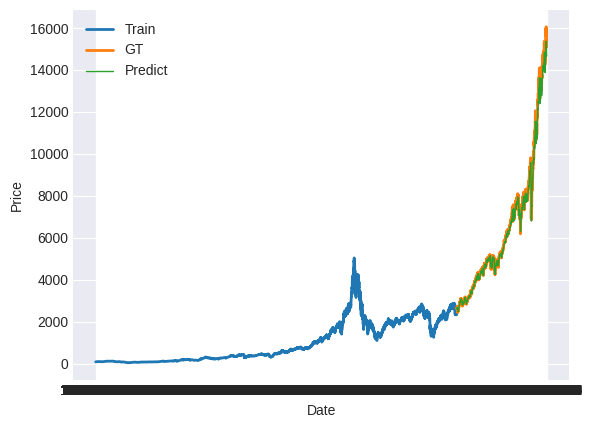

In [42]:
train_df=df[:train_size+daysize]
test_df=df[train_size+daysize:]
test_df=test_df.assign(Predict=preds)

plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(train_df["GT"],linewidth=2)
plt.plot(test_df["GT"],linewidth=2)
plt.plot(test_df["Predict"],linewidth=1)
plt.legend(["Train","GT","Predict"])
plt.show()

#預測最終收市價

In [43]:
data_2 = df
temp = data_2[-60:].values
temp_scaled = scaler.transform(temp)
X_test_2 = []
X_test_2.append(temp_scaled)
X_test_2 = np.array(X_test_2)
X_test_2 = np.reshape(X_test_2, (X_test_2.shape[0], X_test_2.shape[1], 1))
final_y_predict = model.predict(X_test_2)
final_y_predict = scaler.inverse_transform(final_y_predict)

1/1 [==============================] - 0s 58ms/step


In [49]:
my_submission=pd.DataFrame({'Id':['NASDAQ'],'Expected':int(final_y_predict[0][0])})
my_submission.to_csv('submission1.csv', index=False)

比賽結果：總共上傳了10個不同版本上去但都因格式錯誤而失敗，我上傳的csv與題目給的與題目給的sample output一模一樣

（失敗說明）Evaluation Exception: Unmapped required submission schema columns: Id, Predicted

後來查了一下發現可能是後來查了一下發現可能是kaggle後台的原因，而我這個比賽也已經過期不會有人進行修正了，希望老師高抬貴手不要扣我分

另一個有相同問題的kaggle比賽：https://www.kaggle.com/competitions/covid19-global-forecasting-week-5/discussion/139038

結果分析：所有預測數據數據都非常貼合真實數據，最終的測試結果也是，但即便如此仍無法實際應用於日常股市，畢竟這個模型只參考了收市價去製作模型，其他參數都未使用到，然而股市是千變萬化的，預測股價的工具及技術指標也有千百種，更別說還要考量到宏觀經濟因素、政治因素、公司基本面及消息面

可改善地方：或許之後可以將其他變數加入模型中，如最一開始想嘗試的如最一開始想嘗試的RSI指標、移動平均線等等，甚至是將基本面、消息面的資訊都轉成量化數據，並將測試測試在不同的股票及指數當中